# Libraries

In [ ]:
!pip uninstall transformers torch

In [ ]:
!pip install transformers torch

In [ ]:
import torch
from transformers import AutoFeatureExtractor, SwinForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from torchvision.datasets import GTSRB
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

train_dataset = GTSRB(root='./data', split='train', transform=transform, download=True)
test_dataset = GTSRB(root='./data', split='test', transform=transform, download=True)

100%|██████████| 187M/187M [00:10<00:00, 18.7MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 89.0M/89.0M [00:05<00:00, 16.1MB/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 182kB/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [ ]:
transform_original = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset_original = GTSRB(root='./data', split='train', transform=transform_original, download=True)
test_dataset_original = GTSRB(root='./data', split='test', transform=transform_original, download=True)

In [ ]:
print(f"Images in train dataset: {len(train_dataset)}")
print(f"Images in train dataset: {len(test_dataset)}")

Images in train dataset: 26640
Images in train dataset: 12630


In [ ]:
# for i in range(0, 26000, 1000):
#     image, label = train_dataset[i]
#     plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
#     plt.title(f"Label: {label}")
#     plt.axis("off")
#     plt.show()

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224")
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=43,
    ignore_mismatched_sizes=True
)
model.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([43]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([43, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfO

In [ ]:
# Swin models require images in a specific format. We create a simple data collator that includes preprocessing with the feature extractor.
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack([img for img in images])
    labels = torch.tensor(labels)
    inputs = feature_extractor(images=images, return_tensors="pt")
    inputs["labels"] = labels
    return inputs

In [ ]:
def compute_metrics(pred):
    logits, labels = pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# Training

In [ ]:
# param_grid = {
#     "learning_rate": [2e-5, 1e-5],
#     "batch_size": [8, 16],
#     "num_train_epochs": [3, 5],
#     "weight_decay": [0.01, 0.001],
# }

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
500,3.257000,3.267561
1000,3.167100,3.070182
1500,3.003500,2.950201
2000,2.844400,2.773598
2500,2.716900,2.778918
3000,2.574500,2.634946
3500,2.427300,2.482918
4000,2.222200,2.252144
4500,2.055400,2.144272
5000,1.887200,2.056409


TrainOutput(global_step=9990, training_loss=1.877260851549792, metrics={'train_runtime': 8090.1386, 'train_samples_per_second': 9.879, 'train_steps_per_second': 1.235, 'total_flos': 6.264410220157501e+18, 'train_loss': 1.877260851549792, 'epoch': 3.0})

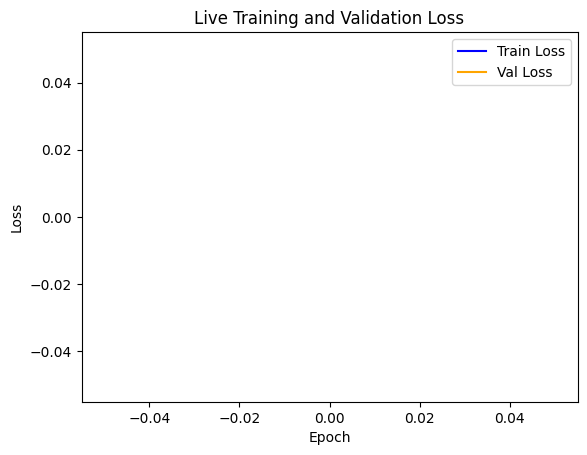

In [ ]:
params = {
    "learning_rate": 2e-5,
    "batch_size": 8,
    "num_train_epochs": 3,
    "weight_decay": 0.01,
}

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}}",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    # callbacks=[live_plot_callback],
    compute_metrics=compute_metrics,  # Pass the function here
)
trainer.train()

In [ ]:
trainer.save_model(f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}")

In [ ]:
log_history = pd.DataFrame(trainer.state.log_history)
log_history.to_csv(f"/content/drive/MyDrive/Deep_learning/training_log_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}.csv", index=False)

In [ ]:
model = SwinForImageClassification.from_pretrained(f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}")

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    # callbacks=[live_plot_callback],
    compute_metrics=compute_metrics,  # Pass the function here
)

eval_results = trainer.evaluate()
print(f"Accuracy on validation set: {eval_results}")  # This will include accuracy and other metrics if defined

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Accuracy on validation set: {'eval_loss': 1.1480019092559814, 'eval_model_preparation_time': 0.0064, 'eval_accuracy': 0.6548693586698338, 'eval_runtime': 243.9101, 'eval_samples_per_second': 51.781, 'eval_steps_per_second': 6.474}


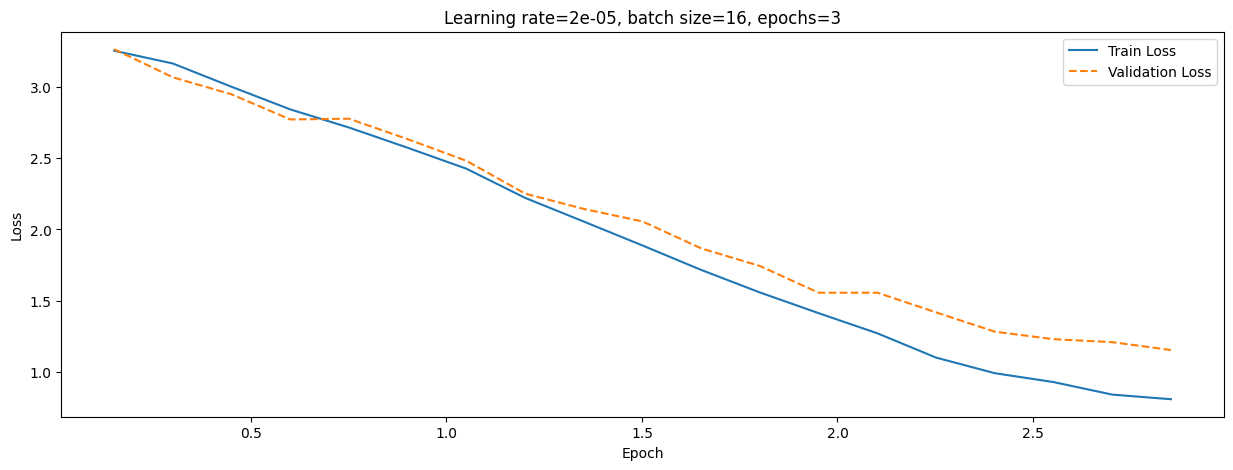

In [ ]:
log_history = pd.read_csv(f"/content/drive/MyDrive/Deep_learning/training_log_2e-05_8_3.csv")

train_loss = log_history[log_history["step"].notna() & log_history["loss"].notna()]
eval_loss = log_history[log_history["step"].notna() & log_history["eval_loss"].notna()]

plt.figure(figsize=(15, 5))

plt.plot(train_loss["epoch"], train_loss["loss"],  label='Train Loss')
plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label='Validation Loss', linestyle='--')
plt.title(f"Learning rate={params['learning_rate']}, batch size={params['batch_size']}, epochs={params['num_train_epochs']}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"Learning rate={params['learning_rate']}, batch size={params['batch_size']}, epochs={params['num_train_epochs']}.png")

In [ ]:
params = {
    "learning_rate": 2e-5,
    "batch_size": 32,
    "num_train_epochs": 5,
    "weight_decay": 0.01,
}

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Accuracy
500,2.127300,1.284713,0.615439
1000,0.629200,0.699305,0.809976
1500,0.475700,0.656119,0.838876
2000,0.421800,0.493003,0.881394
2500,0.393300,0.653797,0.864212
3000,0.374800,0.497928,0.892082
3500,0.375000,0.540222,0.884877
4000,0.355100,0.583279,0.875376


In [ ]:
# trainer.save_model(f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}")
params = {
    "learning_rate": 2e-5,
    "batch_size": 32,
    "num_train_epochs": 5,
    "weight_decay": 0.01,
}

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.state.load_from_json(f"{training_args.output_dir}/checkpoint-4000/trainer_state.json")
log_history = trainer.state.log_history

log_df = pd.DataFrame(log_history)
log_df.to_csv(f"/content/drive/MyDrive/Deep_learning/training_log_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}.csv", index=False)
# log_history = pd.DataFrame(trainer.state.log_history)
# log_history.to_csv(f"/content/drive/MyDrive/Deep_learning/training_log_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}.csv", index=False)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


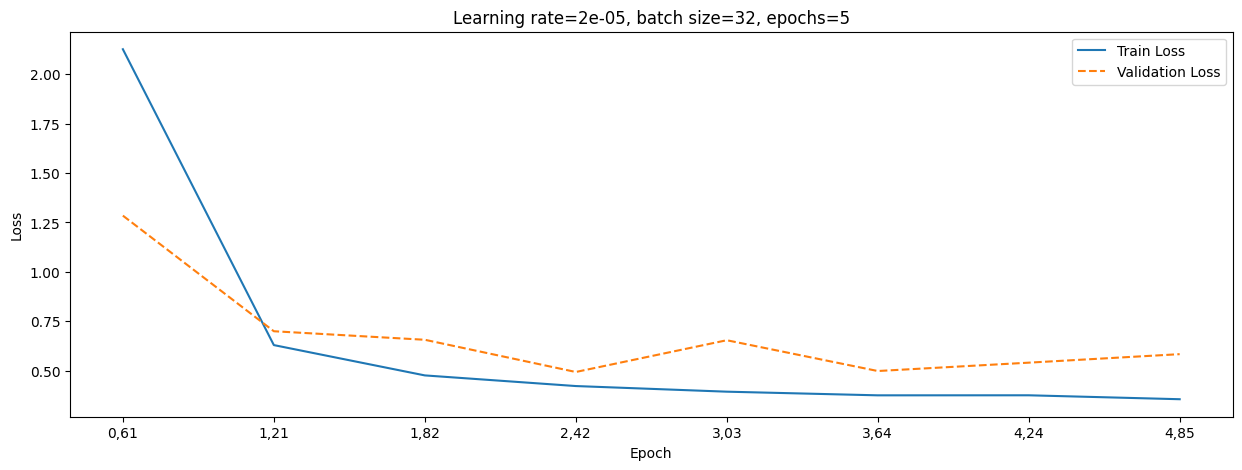

In [ ]:
log_history = pd.read_csv(f"/content/drive/MyDrive/Deep_learning/training_log_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}.csv")
train_loss = log_history[log_history["Step"].notna() & log_history["Training Loss"].notna()]
eval_loss = log_history[log_history["Step"].notna() & log_history["Validation Loss"].notna()]

plt.figure(figsize=(15, 5))

plt.plot(train_loss["Epoch"], train_loss["Training Loss"],  label='Train Loss')
plt.plot(eval_loss["Epoch"], eval_loss["Validation Loss"], label='Validation Loss', linestyle='--')
plt.title(f"Learning rate={params['learning_rate']}, batch size={params['batch_size']}, epochs={params['num_train_epochs']}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"Learning rate={params['learning_rate']}, batch size={params['batch_size']}, epochs={params['num_train_epochs']}.png")

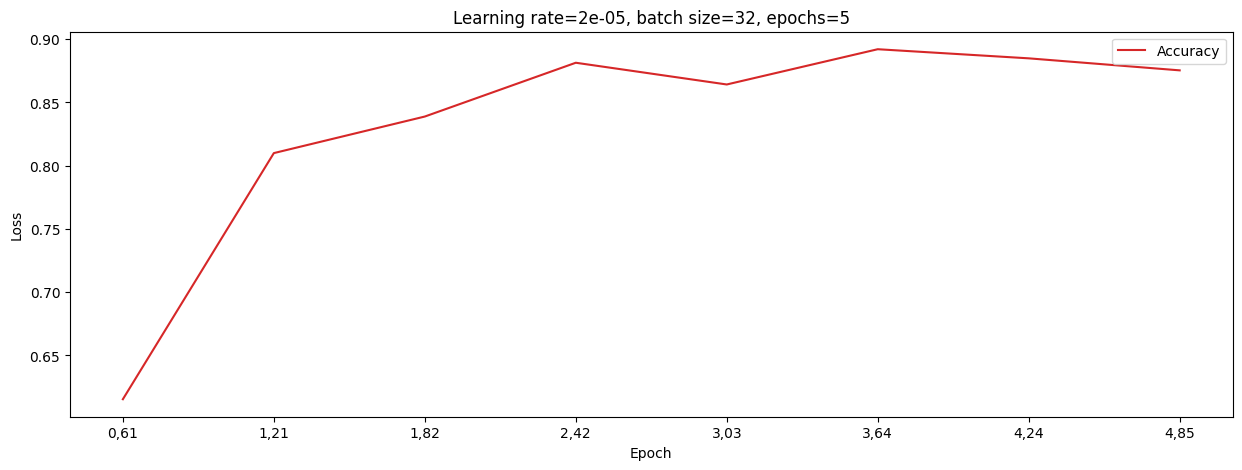

In [ ]:
plt.figure(figsize=(15, 5))
accuracy = log_history[log_history["Step"].notna() & log_history["Accuracy"].notna()]

plt.plot(eval_loss["Epoch"], accuracy["Accuracy"], label='Accuracy', color='tab:red')
plt.title(f"Learning rate={params['learning_rate']}, batch size={params['batch_size']}, epochs={params['num_train_epochs']}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"Learning rate={params['learning_rate']}, batch size={params['batch_size']}, epochs={params['num_train_epochs']}.png")

In [ ]:
trainer.train(resume_from_checkpoint=f"{training_args.output_dir}/checkpoint-4000/trainer_state.json")
log_history = trainer.state.log_history

log_df = pd.DataFrame(log_history)
log_df.to_csv(f"/content/drive/MyDrive/Deep_learning/training_log_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}_retrained.csv", index=False)

In [ ]:
params = {
    "learning_rate": 2e-5,
    "batch_size": 32,
    "num_train_epochs": 5,
    "weight_decay": 0.01,
}

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}",
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
trainer.train(resume_from_checkpoint="/content/drive/MyDrive/Deep_learning/swin-gtsrb_2e-05_32_5/checkpoint-4000")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weight

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2833: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

Step,Training Loss,Validation Loss


TrainOutput(global_step=4165, training_loss=0.013309429301505759, metrics={'train_runtime': 326.1794, 'train_samples_per_second': 408.364, 'train_steps_per_second': 12.769, 'total_flos': 1.0440683700262502e+19, 'train_loss': 0.013309429301505759, 'epoch': 5.0})

In [ ]:
params = {
    "learning_rate": 2e-5,
    "batch_size": 32,
    "num_train_epochs": 5,
    "weight_decay": 0.001,
}

model = SwinForImageClassification.from_pretrained("/content/drive/MyDrive/Deep_learning/swin-gtsrb_2e-05_32_5/checkpoint-4165", num_labels=43)

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}",
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
trainer.train(resume_from_checkpoint=False)

Step,Training Loss,Validation Loss,Accuracy
500,0.405700,0.649087,0.848931
1000,0.411800,0.741720,0.839588


KeyboardInterrupt: 

In [ ]:
params = {
    "learning_rate": 2e-5,
    "batch_size": 32,
    "num_train_epochs": 5,
    "weight_decay": 0.01,
}

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=43,
    ignore_mismatched_sizes=True
)
model.to("cuda")

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
    load_best_model_at_end = True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([43]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([43, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,3.453300,3.374732,0.082502
1000,3.351800,3.382044,0.076960


In [ ]:
params = {
    "learning_rate": 2e-5,
    "batch_size": 32,
    "num_train_epochs": 5,
    "weight_decay": 0.01,
}

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=43,
    ignore_mismatched_sizes=True
)
model.to("cuda")

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
    load_best_model_at_end = True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([43]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([43, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-c90ad695d72c>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
500,3.434400,3.340194,0.095962
1000,3.290300,3.192493,0.114885
1500,3.047000,2.903939,0.147031
2000,2.704500,2.637266,0.235788
2500,2.445200,2.401484,0.271101


In [ ]:
params = {
    "learning_rate": 2e-5,
    "batch_size": 32,
    "num_train_epochs": 10,
    "weight_decay": 0.01,
}

# model = SwinForImageClassification.from_pretrained(
#     "microsoft/swin-base-patch4-window7-224",
#     num_labels=43,
#     ignore_mismatched_sizes=True
# )
# model.to("cuda")
model = SwinForImageClassification.from_pretrained(f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_2e-05_32_15/checkpoint-6000")

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
    load_best_model_at_end = True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train(resume_from_checkpoint="/content/drive/MyDrive/Deep_learning/swin-gtsrb_2e-05_32_15/checkpoint-6000")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-15-5e18db6908a0>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3033: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary obj

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

# Evaluate final model

In [ ]:
# can be downloaded from https://drive.google.com/drive/folders/1OYOrdKcBmXTrBbl2dvMISXZcvGYpaUd9?usp=sharing
model = SwinForImageClassification.from_pretrained(f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_2e-05_32_15/checkpoint-11000")
params = {
    "learning_rate": 2e-5,
    "batch_size": 32,
    "num_train_epochs": 15,
    "weight_decay": 0.01,
}

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Deep_learning/swin-gtsrb_{params['learning_rate']}_{params['batch_size']}_{params['num_train_epochs']}",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    logging_dir='./logs',
    load_best_model_at_end = True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_original,
    eval_dataset=test_dataset_original,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-f1d01c54712f>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
predictions, labels, _ = trainer.predict(test_dataset_original)
pred_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(labels, pred_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(labels, pred_labels, target_names=[str(i) for i in range(43)]))

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Accuracy: 96.63%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      0.99       720
           2       0.97      0.99      0.98       750
           3       0.98      0.97      0.97       450
           4       0.98      0.99      0.98       660
           5       0.91      0.95      0.93       630
           6       0.97      0.99      0.98       150
           7       0.99      0.88      0.93       450
           8       0.96      0.95      0.96       450
           9       0.97      0.99      0.98       480
          10       0.99      1.00      0.99       660
          11       0.96      0.90      0.93       420
          12       1.00      0.96      0.98       690
          13       0.96      1.00      0.98       720
          14       1.00      0.99      0.99       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          

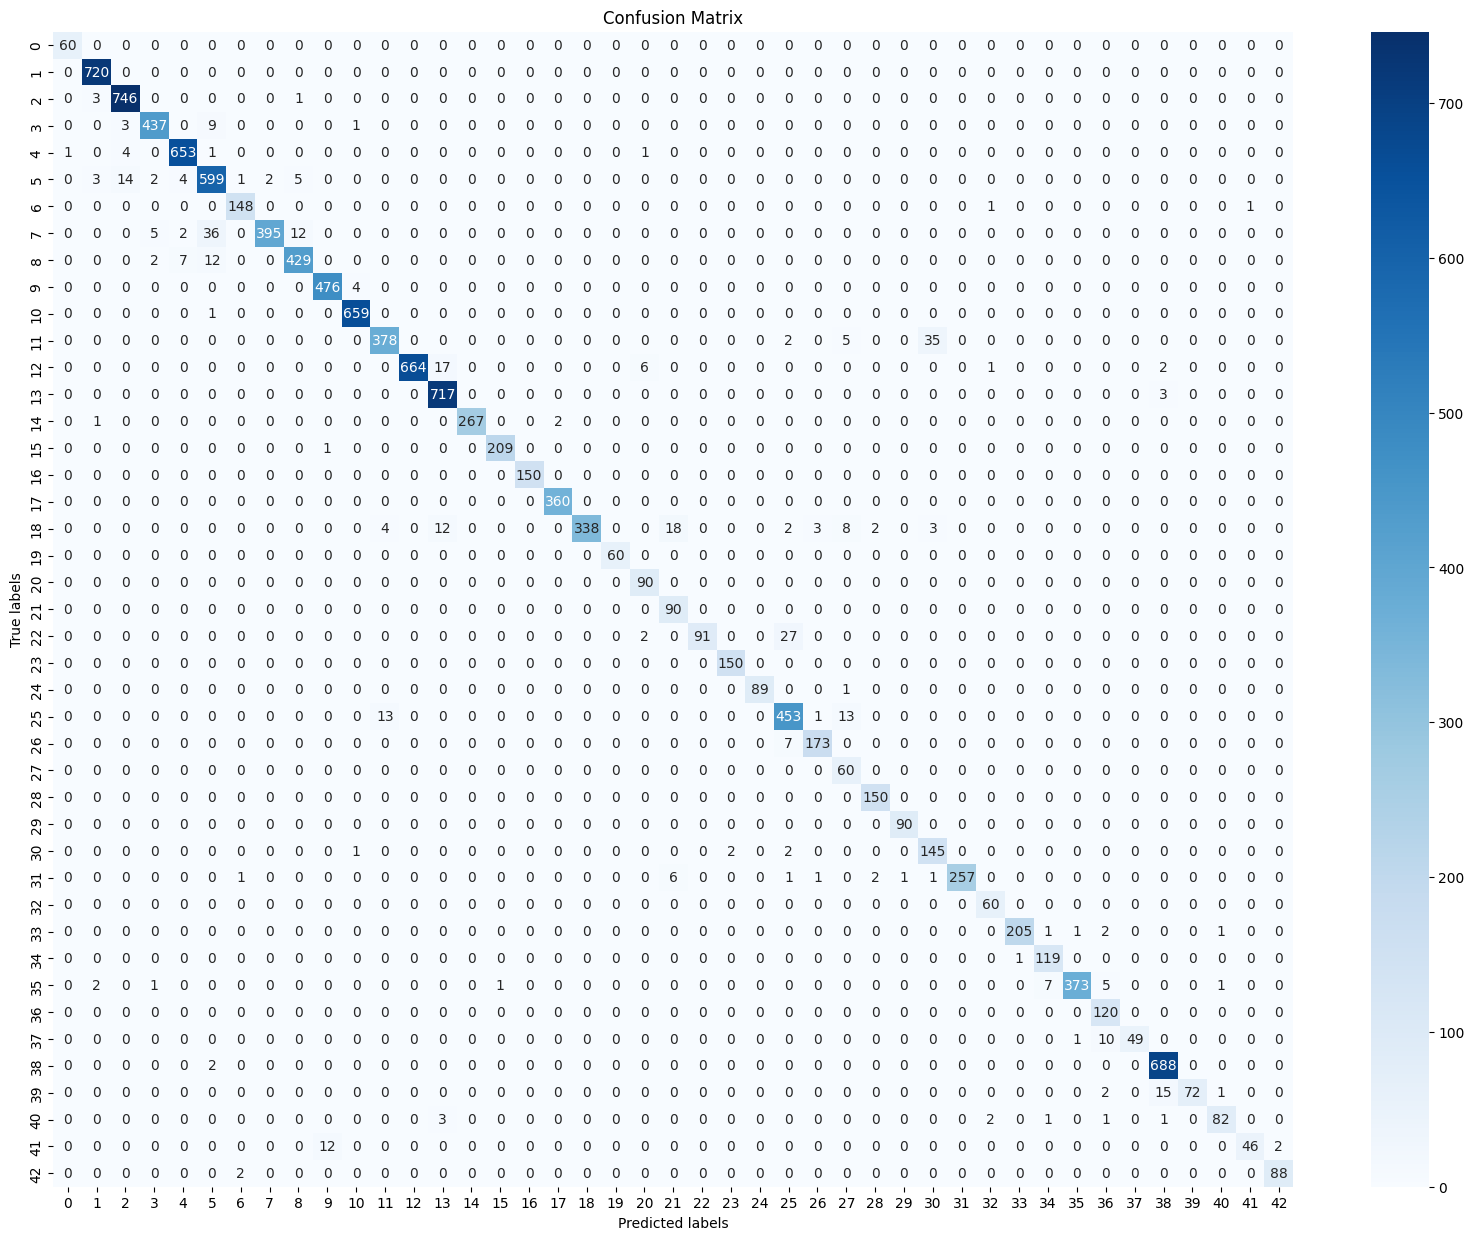

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(43)], yticklabels=[str(i) for i in range(43)])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()

In [ ]:
def occlusion_sensitivity(device, image, model, label, window_size=8, stride=4):
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    model.eval()
    _, _, h, w = image.shape
    occlusion_map = np.zeros((h, w))

    with torch.no_grad():
        baseline_output = model(image)  # Get the output from the model
        if hasattr(baseline_output, 'logits'):  # Extract logits if present in output
            baseline_logits = baseline_output.logits
        else:
            baseline_logits = baseline_output  # Assume the output is directly logits

        baseline_confidence = torch.softmax(baseline_logits, dim=1)[0, label].item()

    for i in range(0, h - window_size + 1, stride):
        for j in range(0, w - window_size + 1, stride):
            occluded_image = image.clone()
            occluded_image[:, :, i:i+window_size, j:j+window_size] = 0  # Zero-out the window

            with torch.no_grad():
                output = model(occluded_image)  # Get the output from the model
                if hasattr(output, 'logits'):  # Extract logits if present in output
                    logits = output.logits
                else:
                    logits = output  # Assume the output is directly logits

                confidence = torch.softmax(logits, dim=1)[0, label].item()

            occlusion_map[i:i+window_size, j:j+window_size] += baseline_confidence - confidence

    occlusion_map = (occlusion_map - occlusion_map.min()) / (occlusion_map.max() - occlusion_map.min())
    return occlusion_map

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for i in range(0, 26000, 1000):
  image, label = train_dataset_original[i]
  occlusion_map = occlusion_sensitivity(device, image, model, label)

  # Create a side-by-side plot
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Plot the original image
  axes[0].imshow(image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
  axes[0].set_title(f"Original Image - Label: {label}")
  axes[0].axis("off")

  # Plot the occlusion map overlay
  im = axes[1].imshow(image.permute(1, 2, 0))  # Display original image in background
  axes[1].imshow(occlusion_map, cmap="hot", alpha=0.5)  # Overlay occlusion map
  axes[1].set_title("Saliency by Occlusion")
  axes[1].axis("off")

  # Add a colorbar to the second plot
  cbar = fig.colorbar(im, ax=axes[1], orientation="vertical", label="Importance")
  cbar.set_alpha(0.5)  # Optional: adjust colorbar transparency
  # cbar.draw_all()

  # Show the plot
  plt.tight_layout()
  plt.show()